Authors: Fernando Díaz González and Giorgio Ruffa
{fdiaz, ruffa}@kth.se

Group 29

ID 2222 Data Mining. Assignment 4

# Graph Spectra

Implementation of the paper:

Andrew Y. Ng, Michael I. Jordan, and Yair Weiss. 2001. On spectral clustering: analysis and an algorithm. In Proceedings of the 14th International Conference on Neural Information Processing Systems: Natural and Synthetic (NIPS'01).

## Introduction

We will start by implementing the algorithm and testing it on a so-called "toy example", a very simple graph with two clear communities on which we can manually check every stage of the computation.

Then we will create a dedicated function for the whole algorithm and test it on the two suggested example datasets.

We will investigate further the distribution of the sorted eigenvalues and propose a simple procedure to identify a "good" number of communities.

The obtained communities are then plotted by colouring the nodes with different colours, depending on the cluster they belong.

We will use the standard python tools for dealing with graphs, linear algebra and kmeans clustering.

In [2]:
import networkx as nx
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import scipy

from collections import defaultdict
from networkx import Graph
from sklearn.cluster import KMeans

## K-eigenvector algorithm

The algorithm proposed by Ng at All. revolves around the spectral decomposition of the normalized laplacian matrix $L = D^{-1/2} A D^{-1/2}$. 

Where $D$ is the so-called degree matrix, a diagonal matrix where the i-th element of the diagonal is the sum of all the elements on the i-th row: $D_{i,i} = d_i = \sum_{j}^{n} A_{i,j}$

The elements of $D^{-1/2}$ are $D^{-1/2}_{i,i} = d_{i}^{-\frac{1}{2}} = \frac{1}{\sqrt{d_{i}}}$.

The $A$ matrix is the affinity matrix, where each element $A_{i,j}$ represent the distance between the elements $i$ and $j$.

In our particular case the affinity matrix is the adjacency matrix, so the not-connected elements are infinitely far apart and the matrix is simmetric.
The paper suggests a different way to calculate $A$ using a "dumping" parameter $\sigma$ which applyes to a general case where the elements of the set $S = \{s_1, ..., s_n\}$ are represented by $l$ dimensional vectors: $s_i \in \mathbb{R}^{l}$

The dimensions of $A$ are $n \times n$, where, in our case, $n$ is the number of vertexes in the graph.

Working on the spectra of the normalized laplacian matrix, we are trying to optimize the conductance of the partitioning, by taking the highest eigenvectors.

The conductance is defined as follow:
$$
J_{con} = \sum_{i}^{k} \frac{W(S_i,\bar{S}_j)}{W(S_i,V)}
$$

Where $W(S_i,S_j)$ is the sum of the weights of the edges between nodes belonging to set $S_i$ and set $S_j$

Once the $k$ largest eigenvectors are selected, we obtain a matrix $X \in \mathbb{R}^{n\times k}$ by stacking the eigenvectors as columns. The eigenvectors represent a base of a vector space of reduced dimensionality on which we can project our original elements (vectors) that are represented by the row of the $X$ matrix.

This implies that the eigenvectors are not binary, hence assigning each element of $S$ to a cluster is not trivial. To overcome this problem the rows of $X$ are normalized creating a new matrix $Y \in \mathbb{R}^{n \times k}$, and then clustered using k-means algorithm into k-clusters. The element $s_i$ will be assigned to cluster $j \in {1,...,k}$ if the i-th row of X belongs to cluster $j$

## Toy example

In [17]:
test_graph = nx.read_edgelist('test_graph.edgelist', create_using=Graph, edgetype=str)

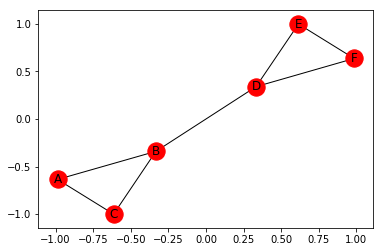

In [90]:
nx.draw_networkx(test_graph, seed=42)

1. Form the affinity matrix $A \in \mathbb{R}^{n \times n}$ defined by $A_{ij} = exp(-||s_i - s_j||^2 / 2\sigma^2)$ if $i \ne j$, and $A_{ii} = 0$. 

In [21]:
A = nx.adjacency_matrix(test_graph, nodelist=sorted(test_graph.nodes))
print('A matrix:')
print(A.todense())
print(sorted(test_graph.nodes))

A matrix:
[[0 1 1 0 0 0]
 [1 0 1 1 0 0]
 [1 1 0 0 0 0]
 [0 1 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]]
['A', 'B', 'C', 'D', 'E', 'F']


2. Define $D$ to be the diagonal matrix whose $(i, i)$-element is the sum of $A$'s $i$-th
row, and construct the matrix $L = D^{-1/2} A D^{-1/2}$. 

In [23]:
np.set_printoptions(precision=3)

D = np.zeros(A.shape)
# axis=1 -> sum per row
grades = A.sum(axis=1)
np.fill_diagonal(D, grades)
print('D matrix:')
print(D)
print()

# Calculate D^(-1/2)
D_p = D.copy()
np.fill_diagonal(D_p, 1 / np.sqrt(grades))
print('D^-0.5 matrix')
print(D_p)
print()

# Calculate L
L = D_p.dot(A.todense()).dot(D_p)
# Also valid
# L = -nx.normalized_laplacian_matrix(test_graph)
print('L matrix:')
print(L)
print()

D matrix:
[[2. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]

D^-0.5 matrix
[[0.707 0.    0.    0.    0.    0.   ]
 [0.    0.577 0.    0.    0.    0.   ]
 [0.    0.    0.707 0.    0.    0.   ]
 [0.    0.    0.    0.577 0.    0.   ]
 [0.    0.    0.    0.    0.707 0.   ]
 [0.    0.    0.    0.    0.    0.707]]

L matrix:
[[0.    0.408 0.5   0.    0.    0.   ]
 [0.408 0.    0.408 0.333 0.    0.   ]
 [0.5   0.408 0.    0.    0.    0.   ]
 [0.    0.333 0.    0.    0.408 0.408]
 [0.    0.    0.    0.408 0.    0.5  ]
 [0.    0.    0.    0.408 0.5   0.   ]]



3. Find $x_1, x_2, \cdots , x_k$, the $k$ largest eigenvectors of $L$ (chosen to be orthogonal to each other in the case of repeated eigenvalues), and form the matrix $X = [x_1 x_2 \cdots x_k] \in \mathbb{R}^{n \times k}$ by stacking the eigenvectors in columns. 

In [33]:
# get the eigenvalues and eigenvectors
eigenval, eigenvec = np.linalg.eig(L)
eigenvec = eigenvec.T  # The eigenvectors are stacked in coulmn by np, we take them by row!
print('Eigenvalues: ', eigenval)
print('Eigenvectors:', eigenvec)
print()

k = 2  # because we know it
# we buld the matrix X using the largest eigenvectors
idx_sorted = np.argsort(eigenval)[::-1]  # -1 to sort descending
largest_eigenval = eigenval[idx_sorted[:k]]
largest_eigenvec = eigenvec[idx_sorted[:k]]
X = largest_eigenvec.T

print('Largest {} eigenvalues are: {}\n'.format(k, largest_eigenval))
print('Largest {} eigenvectors are:'.format(k))
print(largest_eigenvec)
print()
print('Matrix X is:')
print(X)

Eigenvalues:  [ 1.     0.795 -0.167 -0.5   -0.629 -0.5  ]
Eigenvectors: [[-3.780e-01 -4.629e-01 -3.780e-01 -4.629e-01 -3.780e-01 -3.780e-01]
 [-4.451e-01 -3.220e-01 -4.451e-01  3.220e-01  4.451e-01  4.451e-01]
 [-3.273e-01  5.345e-01 -3.273e-01  5.345e-01 -3.273e-01 -3.273e-01]
 [-7.071e-01 -3.654e-16  7.071e-01  1.682e-17 -1.737e-16 -7.844e-17]
 [-2.277e-01  6.295e-01 -2.277e-01 -6.295e-01  2.277e-01  2.277e-01]
 [ 6.540e-02  5.959e-17 -6.540e-02 -1.567e-16 -7.041e-01  7.041e-01]]

Largest 2 eigenvalues are: [1.    0.795]

Largest 2 eigenvectors are:
[[-0.378 -0.463 -0.378 -0.463 -0.378 -0.378]
 [-0.445 -0.322 -0.445  0.322  0.445  0.445]]

Matrix X is:
[[-0.378 -0.445]
 [-0.463 -0.322]
 [-0.378 -0.445]
 [-0.463  0.322]
 [-0.378  0.445]
 [-0.378  0.445]]


4. Form the matrix $Y$ from $X$ by renormalizing each of $X$'s rows to have unit length (i.e. $Y_{ij} = X_{ij} / (\sum_j X_{ij}^2)^{1/2}$). 

In [35]:
Y = X / np.sqrt(np.sum(np.square(X), axis=1))
print('Y:')
print(Y)
print()

# check
print('Modulus of each row of Y:')
print(np.sum(np.square(Y), axis=1))

Y:
[[-0.647 -0.762]
 [-0.821 -0.571]
 [-0.647 -0.762]
 [-0.821  0.571]
 [-0.647  0.762]
 [-0.647  0.762]]

Modulus of each row of Y:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


5. Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster them into $k$ clusters via K-means
or any other algorithm (that attempts to minimize distortion).

In [36]:
kmeans_res = KMeans(n_clusters=k).fit(Y)

6.  Finally, assign the original point $S_i$ to cluster $j$ if and only if row $i$ of the matrix
$Y$ was assigned to cluster $j$.

In [165]:
# Drawing "big" graphs is OK. But use with_labels=False
def draw_network_clusters(graph, cluster_assign, node_size=300, with_labels=True):
    k = len(np.unique(cluster_assign))
    nodes = np.array(list(sorted(graph.nodes)))
    labels = {node: str(node) for node in nodes}
    cmap = plt.cm.get_cmap('Set1', k+1)

    pos = nx.spring_layout(graph, seed=42)
    for ki in range(k):
        n_indexes = np.where(cluster_assign == ki)
        n = list(nodes[n_indexes])
        rgb = cmap(ki)[:3]
        color = matplotlib.colors.rgb2hex(rgb)
        
        nx.draw_networkx_nodes(test_graph, pos, nodelist=n, 
                               node_color=color, node_size=node_size)
        if with_labels:
            nx.draw_networkx_labels(test_graph, pos, labels=labels, node_color=color)
    nx.draw_networkx_edges(graph, pos)
    
def draw_compare(graph, cluster_assign, node_size=300, with_labels=True):
    f = plt.figure(figsize=(15, 5))
    ax = f.add_subplot(121)
    nx.draw_networkx(graph, pos=nx.spring_layout(graph, seed=42), 
                     node_size=node_size, with_labels=with_labels)
    plt.title('Original')
    ax2 = f.add_subplot(122)
    draw_network_clusters(graph, cluster_assign, 
                          node_size=node_size, with_labels=with_labels)
    plt.title('Clusters assigned')
    plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

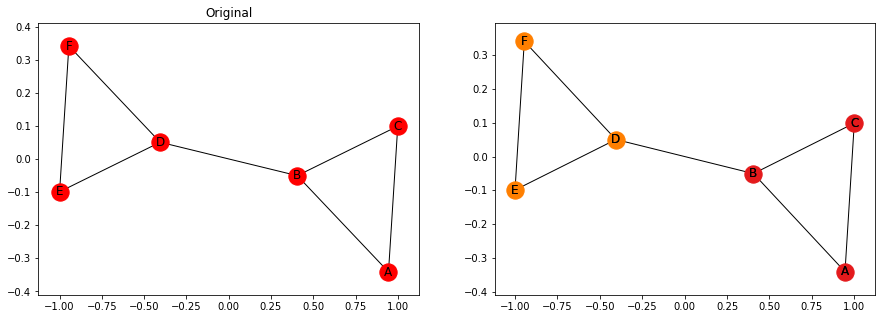

In [164]:
draw_compare(test_graph, kmeans_res.labels_)

## Test with real graph

In [43]:
ex1 = nx.read_edgelist('example1.dat', delimiter=',', create_using=Graph, edgetype=int)
print('Number of nodes: {}. Number of edges {}'.format(ex1.number_of_nodes(), ex1.number_of_edges()))

Number of nodes: 241. Number of edges 923


In [44]:
ex2 = nx.read_weighted_edgelist('example2.dat', delimiter=',', create_using=Graph)
print('Number of nodes: {}. Number of edges {}'.format(ex1.number_of_nodes(), ex1.number_of_edges()))

Number of nodes: 241. Number of edges 923


In [45]:
def spectral_clustering(graph, k=None):
    A = nx.adjacency_matrix(graph,nodelist=sorted(graph.nodes))
    D = np.zeros(A.shape)
    grades = np.sum(A.todense(), axis=1)
    np.fill_diagonal(D, 1 / np.sqrt(grades))
    L = D.dot(A.todense()).dot(D)
    A = D = grades = None  # free memory
    eigenval, eigenvec = np.linalg.eig(L)
    eigenvec = eigenvec.T  # result was column-wise
    # Use eigenvalues to find the best k
    if k == None:
        k = find_best_k(eigenval)
        print('Found best k =', k)
    idx_sorted = np.argsort(eigenval)[::-1]
    largest_eigenvec = eigenvec[idx_sorted[:k]]
    X = largest_eigenvec.T
    Y = X / np.sqrt(np.sum(np.square(X), axis=1))
    np.nan_to_num(Y, copy=False)  # valid? (sometimes, rows of X are all 0's)
    kmeans_res = KMeans(n_clusters=k).fit(Y)
    return kmeans_res.labels_, eigenval

def find_best_k(eigenval, delta=0.1):
    # Check if the difference between two eigenvalues (sorted desc) changes radically
    # The difference between eigen1 and eigen2 is always ok
    # E.g. [1, 0.9, 0.8, 0.6] (1 - 0.9) = 0.1 (ok), (0.9 - 0.8) = 0.1 (ok), (0.8 - 0.6) = 0.2 (stop)
    # E.g. [1, 0.5, 0.4, -0.6] (1 - 0.5) = 0.5 (ok), (0.5 - 0.4) = 0.1 (stop)
    # I agree that last example is a little bit weird, but let's consider that minimum k = 2
    # It works anyway!
    eigenval_sorted = sorted(eigenval, reverse=True)
    previous_diff = eigenval_sorted[0] - eigenval_sorted[1]
    for k in range(1, len(eigenval_sorted)):
        current_diff = eigenval_sorted[k - 1] - eigenval_sorted[k]
        if abs(current_diff - previous_diff) > delta:
            return k
        previous_diff = current_diff
    # If we are here we are DOOMED anyway
    return len(eigenval)

In [54]:
ex1_clusters, ex1_eigenval = spectral_clustering(ex1, k=None)

Found best k = 4


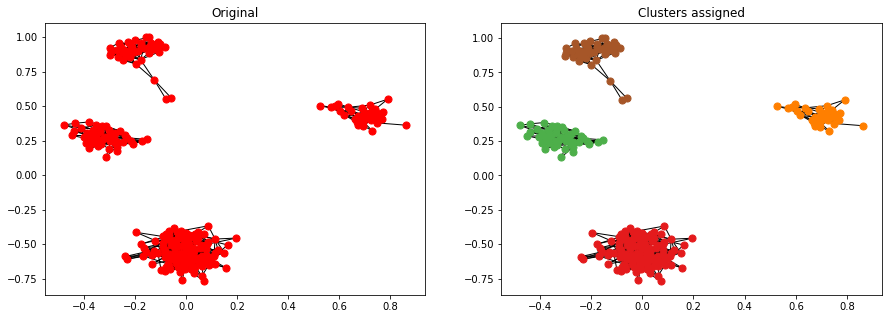

In [55]:
draw_compare(ex1, ex1_clusters, node_size=50, with_labels=False)

The graph has 4 disconnected components and the number of clusters coincides with 4.

Can we go further by splitting each connected component?

### Eigenvalues analysis
In order to find the second-best k we can analyse further the distribution of the sorted eigenvalues

First 11 eigenvalues (sorted):
[1.0000000000000022, 1.0000000000000004, 0.9999999999999989, 0.9999999999999963, 0.8323227183309385, 0.7785133509368746, 0.7534709952573856, 0.7508064940326413, 0.7366176410796713, 0.7267992817159721, 0.6376313298484299]


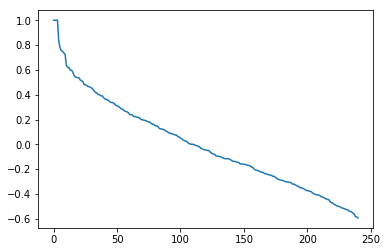

In [57]:
ex1_eigenval_sorted = sorted(ex1_eigenval, reverse=True)
print('First 11 eigenvalues (sorted):')
print(ex1_eigenval_sorted[:11])
plt.plot(range(len(ex1_eigenval_sorted)), ex1_eigenval_sorted)

It appears that there is a first drop around 4 and then a second one close to 10, we can see it better by differenciating.

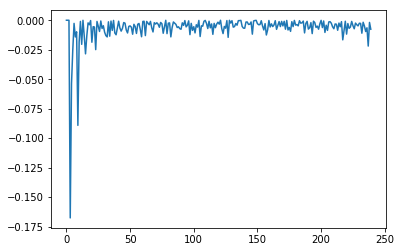

In [58]:
plt.plot(range(len(ex1_eigenval_sorted)-1), np.diff(ex1_eigenval_sorted))

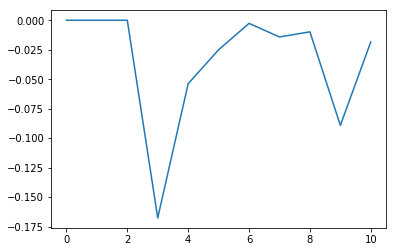

In [102]:
plt.plot(range(len(ex1_eigenval_sorted)-1)[:11], np.diff(ex1_eigenval_sorted)[:11])

Keeping in mind that we are differenciating, the $k$ correspond to the spike in position $x+1$. Let's see what happens for k=10

In [104]:
ex1_clusters, ex1_eigenval = spectral_clustering(ex1, k=10)

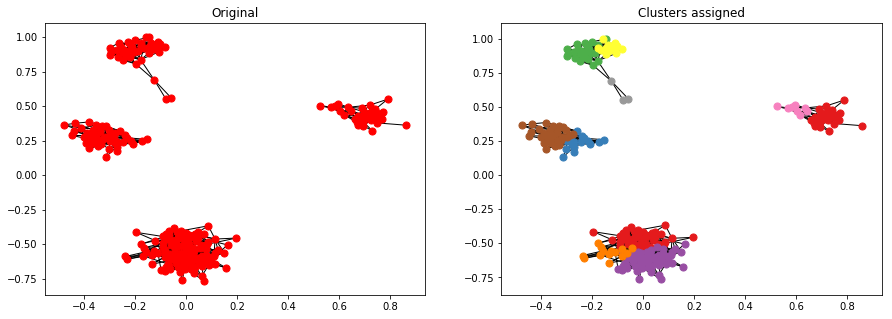

In [105]:
draw_compare(ex1, ex1_clusters, node_size=50, with_labels=False)

### The synthetic graph

In [106]:
ex2_clusters, ex2_eigenval = spectral_clustering(ex2, k=None)

Found best k = 2


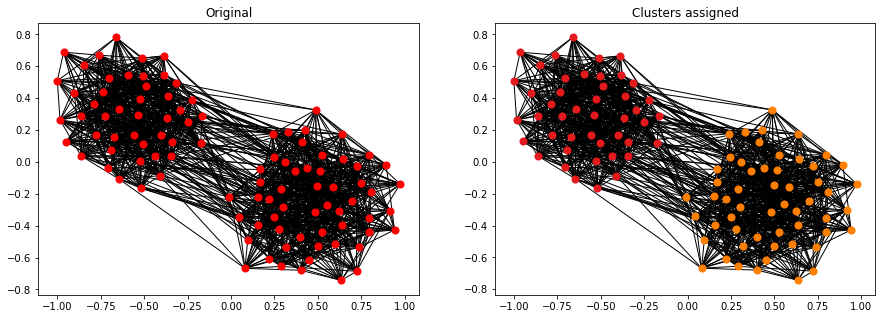

In [107]:
draw_compare(ex2, ex2_clusters, node_size=50, with_labels=False)

It is clear that we have two main clusters.

In fact, if we check the distribution of the eigenvalues

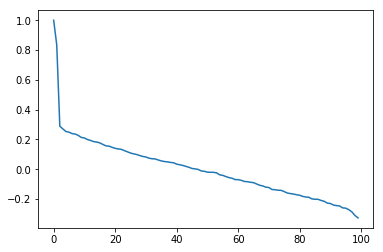

In [108]:
ex2_eigenval_sorted = sorted(ex2_eigenval, reverse=True)
plt.plot(range(len(ex2_eigenval_sorted)), ex2_eigenval_sorted)

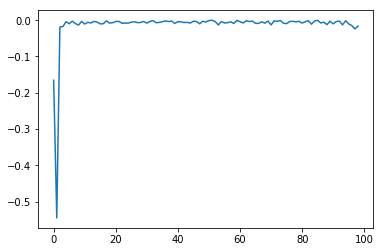

In [109]:
ex2_eigenval_sorted = sorted(ex2_eigenval, reverse=True)
plt.plot(range(len(ex2_eigenval_sorted)-1), np.diff(ex2_eigenval_sorted))

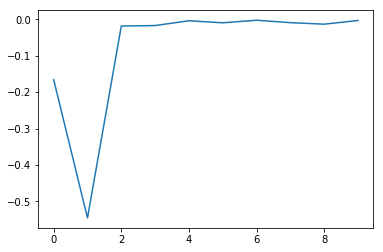

In [113]:
ex2_eigenval_sorted = sorted(ex2_eigenval, reverse=True)
plt.plot(range(len(ex2_eigenval_sorted)-1)[:10], np.diff(ex2_eigenval_sorted)[:10])

As expected the peak is in position 1, so the k is 2

## Appendix
Just for fun we try to find an alternative method to identify the candidates k to split by detecting the spikes in the derivative of the series of sorted eigenvalues

In [142]:
ex1_eigenval_sorted_diff = np.diff(ex1_eigenval_sorted)
mean = np.mean(ex1_eigenval_sorted_diff)
median = np.median(ex1_eigenval_sorted_diff)
std = np.std(ex1_eigenval_sorted_diff)

print("Mean: {} - Median: {} - STD: {}".format(mean,median,std))


candidates = np.argwhere(ex1_eigenval_sorted_diff < (median - 4*std)) + 1
print(candidates)


Mean: -0.006637777098552002 - Median: -0.00457165216439509 - STD: 0.01307422756173817
[[ 4]
 [10]]


In [152]:
def find_candidate_k(eigenval):
    eigenval_sorted = sorted(eigenval, reverse=True)
    eigenval_sorted_diff = np.diff(eigenval_sorted)
    mean = np.mean(eigenval_sorted_diff)
    median = np.median(eigenval_sorted_diff)
    std = np.std(eigenval_sorted_diff)

    print("Mean: {} - Median: {} - STD: {}".format(mean,median,std))

    candidates = np.argwhere(eigenval_sorted_diff < (median - 4*std)) + 1  # 4 * std, totally rule of thumb... Maybe IQR is better...
    return np.ndarray.flatten(candidates)

In [153]:
find_candidate_k(ex1_eigenval_sorted)

Mean: -0.006637777098552002 - Median: -0.00457165216439509 - STD: 0.01307422756173817


array([ 4, 10])

In [154]:
find_candidate_k(ex2_eigenval_sorted)

Mean: -0.013395496472247758 - Median: -0.005398547030657855 - STD: 0.0561812727400123


array([2])

Seems to work for the graphs we have...